In [1]:
import numpy as np
import pandas as pd
import tables as tb

import invisible_cities.reco.peak_functions as rp
from invisible_cities.database import load_db

import matplotlib.pyplot as plt

import invisible_cities.reco.calib_sensors_functions as csf
from invisible_cities.types.ic_types import minmax
from invisible_cities.evm.pmaps import S1, S2

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 12, 4
font_size    = 14

plt.rcParams["figure.figsize"]  = figure_size
plt.rcParams[  "font.size"   ]  = font_size
plt.rcParams[  "image.cmap"  ]  = default_cmap
plt.rcParams["axes.facecolor"]  = 'ghostwhite'
plt.rcParams["axes.grid"     ]  = True
plt.rcParams["grid.color"    ]  = 'lightgrey'
plt.rcParams["axes.formatter.limits"] = -4, 4
plt.rcParams["font.family"]='serif'

#plt.style.use(plt.style.available[10])

In [3]:
def calibratedwf(wf):
    '''Given a CWF (for all PMT), it returns the total calibrated wf'''
    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
#     calwf = calwfs.sum(axis=0)
    return calwf


def s1finder(wf):
    
    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
    wf = calwf.sum(axis=0)
    
    rms = 0.5
    index = np.argwhere(wf>rms).flatten()
    
    time = minmax(0, 640)*1000
    length = minmax(4, 100)
    stride = 4
    rebin_stride = 1

    pmt_ids = np.arange(12)
    Pk = S1
    
    ccwfs = calwf
    res = rp.find_peaks(ccwfs, index,
                   time, length,
                   stride, rebin_stride,
                   Pk, pmt_ids,
                   sipm_wfs=None, thr_sipm_s2=0)
    
    #selection of the s1 with maximum height
    h = np.array([s1.height for s1 in res])
    idxs1 = np.argmax(h)
    s1 = res[idxs1]
    
    return s1


def s2finder(wf):

    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
    wf = calwf.sum(axis=0)
    
    rms = 0.5
    index = np.argwhere(wf>rms).flatten()
    
    time = minmax(640, 1300)*1000
    length = minmax(100, 1e4)
    stride = 40
    rebin_stride = 1

    pmt_ids = np.arange(12)
    Pk = S2
    
    ccwfs = calwf
    res = rp.find_peaks(ccwfs, index,
                   time, length,
                   stride, rebin_stride,
                   Pk, pmt_ids,
                   sipm_wfs=None, thr_sipm_s2=0)
    return res

# IMPORT WFS AND PMAPS

In [4]:
#wfs
peak = 'Tl_double_escape'
wfdir  = f'./DATA/'
wffilename = f'selected_cwf_{peak}_000.h5'
run = 6482

file = tb.open_file(wfdir+wffilename)
wfs_by_event = file.root.BLR.pmtcwf
events = np.array([x['evt_number'] for x in file.root.Run.events.iterrows()])


directory = '/home/gonzalo/Documentos/NEXT/ICAROSNB/GDL/DATA/'
filename  = f'cepks_{run}_0000_11999_6q0min.h5'

data = pd.HDFStore(directory + filename)['/esum']
data['time']=data['time']*10**-10

data = data[np.in1d(data.event.values, events)]
data = data[data.peak==0]

# SINGLE EVENT WF STUDY

In [5]:
i=int(np.random.random()*len(wfs_by_event))
wfs = wfs_by_event[i]
calwfs = calibratedwf(wfs)

print()
print(f'Event to study: {events[i]}')
print()


Event to study: 1571550



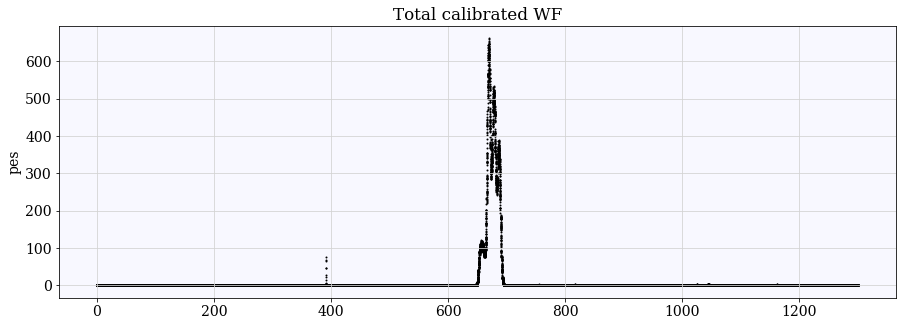

In [6]:
t = np.arange(len(wfs.sum(axis=0)))/40

fig = plt.figure(figsize=[15, 5])

ax = fig.add_subplot(111)
ax.set_title('Total calibrated WF')
ax.scatter(t, calwfs.sum(axis=0), c='black', s=1)
ax.set_ylabel('pes');

### Searching S1 and S2

In [7]:
s1 = s1finder(wfs)
s2 = s2finder(wfs)[0]

s1tim = s1.times/1000
s2tim = s2.times/1000

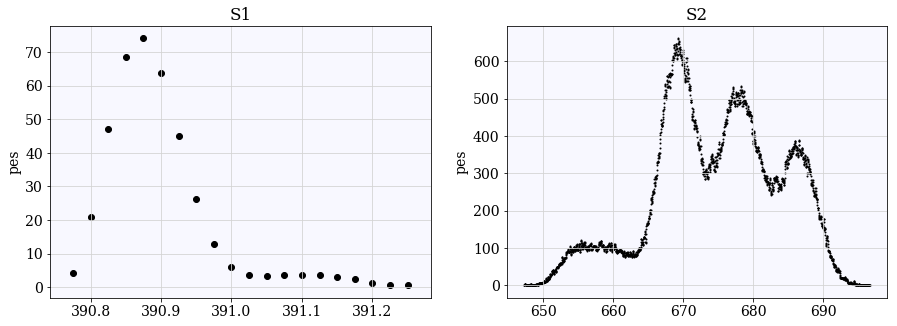

In [8]:
t = np.arange(len(wfs.sum(axis=0)))/40

fig = plt.figure(figsize=[15, 5])

ax = fig.add_subplot(121)
ax.set_title('S1')
idx = np.argwhere((s1tim[0]<=t)&(t<=s1tim[-1])).flatten()
ax.scatter(t[idx], calwfs.sum(axis=0)[idx], c='black')
ax.set_ylabel('pes')

ax = fig.add_subplot(122)
ax.set_title('S2')
idx = np.argwhere((s2tim[0]<=t)&(t<=s2tim[-1])).flatten()
ax.scatter(t[idx], calwfs.sum(axis=0)[idx], c='black', s=1)
ax.set_ylabel('pes');

## SATURATING EVENTS

In [9]:
adc_th = 2000
npmt_cut = 1

sat_evs = []

for i in range(0, len(events)):
    wfs = wfs_by_event[i]
    
    maxs = wfs.max(axis=1)
    npmts_above_adc_th = len(maxs[maxs>adc_th])
    
    if npmts_above_adc_th>=npmt_cut: sat_evs.append(i)

sat_evs = np.array(sat_evs)

print()
print(f'Number of events that saturate: {len(sat_evs)}/{len(events)}')


Number of events that saturate: 2141/3758


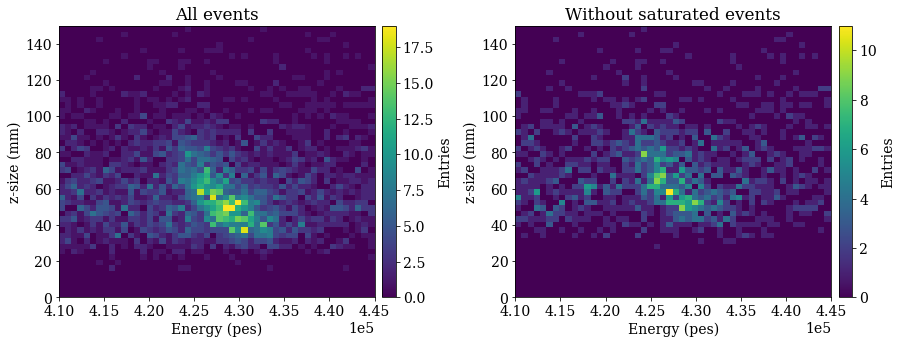

In [10]:
nbins=50
e1, e2 = 4.1e5, 4.45e5
z1, z2 = 0, 150

fig = plt.figure(figsize=[15, 5])

ax = fig.add_subplot(121)
ax.set_title('All events')
ht=ax.hist2d(data.e, data.zsize, range=((e1, e2), (z1, z2)), bins=nbins);
cbar = fig.colorbar(ht[3], ax = ax, pad=0.02)
cbar.ax.set_ylabel('Entries')
ax.set_ylabel('z-size (mm)')
ax.set_xlabel('Energy (pes)');

ax = fig.add_subplot(122)
ax.set_title('Without saturated events')

data_without_sat = data[~np.in1d(data.event.values, events[sat_evs])]

ht=ax.hist2d(data_without_sat.e, data_without_sat.zsize, range=((e1, e2), (z1, z2)), bins=nbins);
cbar = fig.colorbar(ht[3], ax = ax, pad=0.02)
cbar.ax.set_ylabel('Entries')
ax.set_ylabel('z-size (mm)')
ax.set_xlabel('Energy (pes)');